In [1]:
!git clone https://github.com/ITMO-NSS-team/BAMT
import sys
sys.path.insert(0,'/content/BAMT')

fatal: destination path 'BAMT' already exists and is not an empty directory.


In [ ]:
!pip install Cython
!pip install pomegranate
!pip install pgmpy
!pip install deap
!pip install gmr
!pip install pyvis

In [3]:
from sklearn import preprocessing, metrics, model_selection
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator, BayesianEstimator
import networkx as nx
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc
from scipy.stats import norm, gamma

**Data import**

In [4]:
car_sales = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Car_Sales.csv', sep=',')
del car_sales['Unnamed: 0']
car_sales

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Country,Tax_type
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150,Japan,2.0
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778,Japan,5.0
2,Acura,CL,14.114,18.225,Passenger,30.60,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,91.361224,Japan,5.0
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779,Japan,5.0
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639,Germany,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Volvo,V40,3.545,NaN,Passenger,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,9/21/2011,66.498812,Sweden,3.0
152,Volvo,S70,15.245,NaN,Passenger,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,11/24/2012,70.654495,Sweden,3.0
153,Volvo,V70,17.531,NaN,Passenger,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,6/25/2011,71.155978,Sweden,3.0
154,Volvo,C70,3.493,NaN,Passenger,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,4/26/2011,101.623357,Sweden,6.0


**Choosing features**

In [5]:
columns = ['Price_in_thousands','Fuel_efficiency','Power_perf_factor','Wheelbase','Engine_size','Horsepower','Tax_type','Fuel_capacity','Length','Curb_weight','Country','Manufacturer']
data = car_sales[columns]
chosen_features = ['Price_in_thousands','Fuel_efficiency','Power_perf_factor','Wheelbase','Engine_size','Horsepower','Tax_type','Fuel_capacity','Length','Curb_weight']

**Coding and Discretization**

In [6]:
coded_data, coder = code_categories(data, 'label', ['Manufacturer', 'Country'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', ['Price_in_thousands','Fuel_efficiency','Power_perf_factor','Wheelbase','Engine_size','Horsepower','Fuel_capacity','Length','Curb_weight'])
discrete_data['Tax_type'] = data['Tax_type'].astype(int)

**Sampling**

In [ ]:
def inverse_transform_sampling(n, dist, param):
    gen=np.random.uniform(size=n)                                       
    rv=dist(*param)
    return rv.ppf(gen)

def monte_carlo_sampling(dist, params, size):
    return dist.rvs(*params,size = size)

In [ ]:
n = 2000

price_params = gamma.fit(data['Price_in_thousands'])
fuel_params = norm.fit(data['Fuel_efficiency'])
weight_params = norm.fit(data['Curb_weight'])

sample_price=inverse_transform_sampling(n, gamma, price_params)
sample_fuel=inverse_transform_sampling(n, norm, fuel_params)
sample_weight=inverse_transform_sampling(n, norm, weight_params)

Inverse transform

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


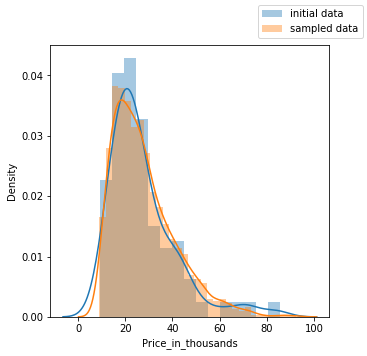

In [20]:
# Price in thousands

fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(data['Price_in_thousands'], kde=True, label='initial data')
sns.distplot(sample_price, kde=True, norm_hist=True, label='sampled data')

fig.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


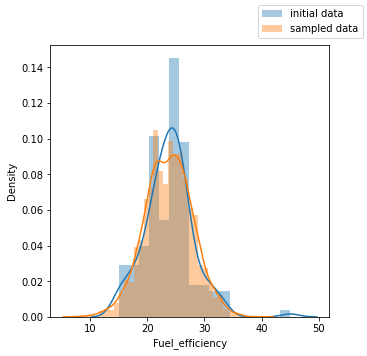

In [23]:
# Fuel efficiency

fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(data['Fuel_efficiency'], kde=True, norm_hist=True, label='initial data')
sns.distplot(sample_fuel, kde=True, norm_hist=True, label='sampled data')

fig.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


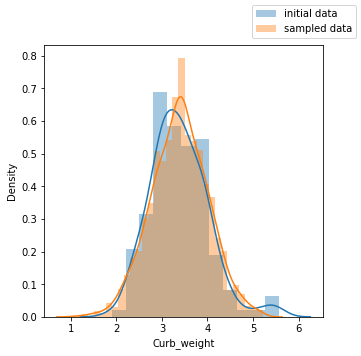

In [25]:
# Curb weight

fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(data['Curb_weight'], kde=True, norm_hist=True, label='initial data')
sns.distplot(sample_weight, kde=True, norm_hist=True, label='sampled data')

fig.legend()

Monte-Carlo

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


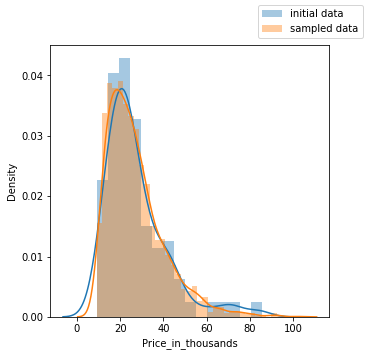

In [29]:
# Price in thousands

fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(data['Price_in_thousands'], label='initial data')
sns.distplot(monte_carlo_sampling(gamma, price_params, 2000), label='sampled data')

fig.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


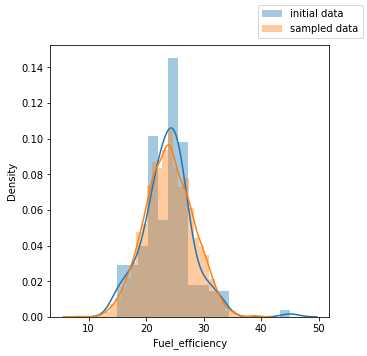

In [31]:
# Fuel efficiency

fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(data['Fuel_efficiency'], label='initial data')
sns.distplot(monte_carlo_sampling(norm, fuel_params, 2000), label='sampled data')

fig.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


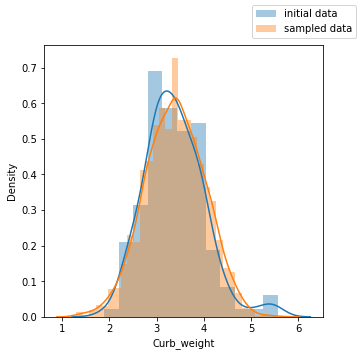

In [32]:
# Curb weight

fig, ax = plt.subplots(figsize = (5,5))

sns.distplot(data['Curb_weight'], label='initial data')
sns.distplot(monte_carlo_sampling(norm, weight_params, 2000), label='sampled data')

fig.legend()

**Correlations**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


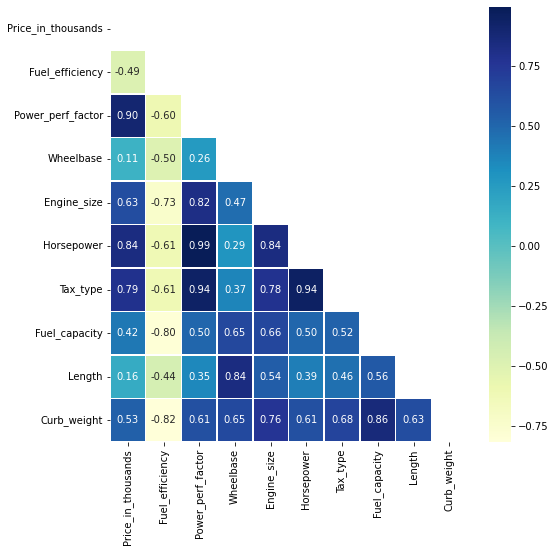

In [33]:
def corr_matrix(df):
  corr = df.corr()
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  f, ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(corr, mask=mask, linewidths=.5, annot=True, fmt='.2f', ax=ax, cmap='YlGnBu')

corr_matrix(data[chosen_features])

**Nodes Characteristics**

In [34]:
nodes_type = get_nodes_type(data[chosen_features])
nodes_type

{'Curb_weight': 'cont',
 'Engine_size': 'cont',
 'Fuel_capacity': 'cont',
 'Fuel_efficiency': 'cont',
 'Horsepower': 'cont',
 'Length': 'cont',
 'Power_perf_factor': 'cont',
 'Price_in_thousands': 'cont',
 'Tax_type': 'cont',
 'Wheelbase': 'cont'}

In [35]:
nodes_sign = get_nodes_sign(data[chosen_features])
nodes_sign

{'Curb_weight': 'pos',
 'Engine_size': 'pos',
 'Fuel_capacity': 'pos',
 'Fuel_efficiency': 'pos',
 'Horsepower': 'pos',
 'Length': 'pos',
 'Power_perf_factor': 'pos',
 'Price_in_thousands': 'pos',
 'Tax_type': 'pos',
 'Wheelbase': 'pos'}

**Structure learing mannual**

In [36]:
def create_edges(connections):

  edges = []
  for outlet, inlet in connections.items():
    for inl in inlet:
      edges.append([outlet, inl])
  
  return edges

connections = {
    "Engine_size": ["Horsepower", "Price_in_thousands", "Fuel_efficiency"],
    "Wheelbase": ["Curb_weight", "Price_in_thousands"],
    "Fuel_capacity": ["Length", "Curb_weight", "Fuel_efficiency"],
    "Price_in_thousands": [],
    "Fuel_efficiency": [],
    "Power_perf_factor": ["Price_in_thousands"],
    "Horsepower": ["Tax_type", "Power_perf_factor"],
    "Tax_type": ["Price_in_thousands"],
    "Length": ["Wheelbase"],
    "Curb_weight": ["Fuel_efficiency"],
}

edges = create_edges(connections)
vertices = ["Engine_size","Wheelbase","Fuel_capacity","Price_in_thousands","Fuel_efficiency","Power_perf_factor","Horsepower","Tax_type","Length","Curb_weight"]
bn = {"V":vertices, "E":edges}

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


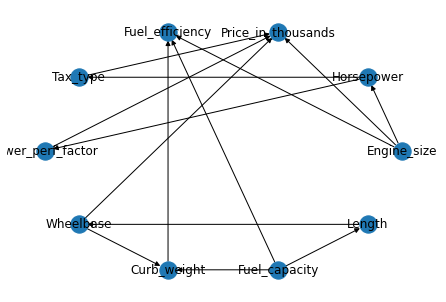

In [37]:
def draw_mannual_structure(edges_list):

  network1 = BayesianModel(edges_list)

  G = nx.DiGraph()
  G.add_edges_from(network1.edges())
  pos = nx.layout.circular_layout(G)
  nx.draw(G, pos=pos, with_labels=True)

draw_mannual_structure(edges)

In [39]:
def mannual_est(features, structure):

  data_for_mannual = data[chosen_features]

  params = parameter_learning(data_for_mannual, nodes_type, bn, 'simple')

  save_structure(bn, 'car_sales_structure')
  skel = read_structure('car_sales_structure')
  save_params(params, 'car_sales_param')
  params = read_params('car_sales_param')
  car_sales_bn = HyBayesianNetwork(skel, params)

  synth_data = generate_synthetics(car_sales_bn, nodes_sign, 'simple', 2000)

  plt.figure(figsize=(24,6))
  counter = 1
  
  for feature in features:

    plt.subplot(1,3,counter)
    sns.distplot(data[feature], label='Real data')
    sns.distplot(synth_data[feature], label='Synthesized data')
    plt.legend()

    counter += 1

  return car_sales_bn

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

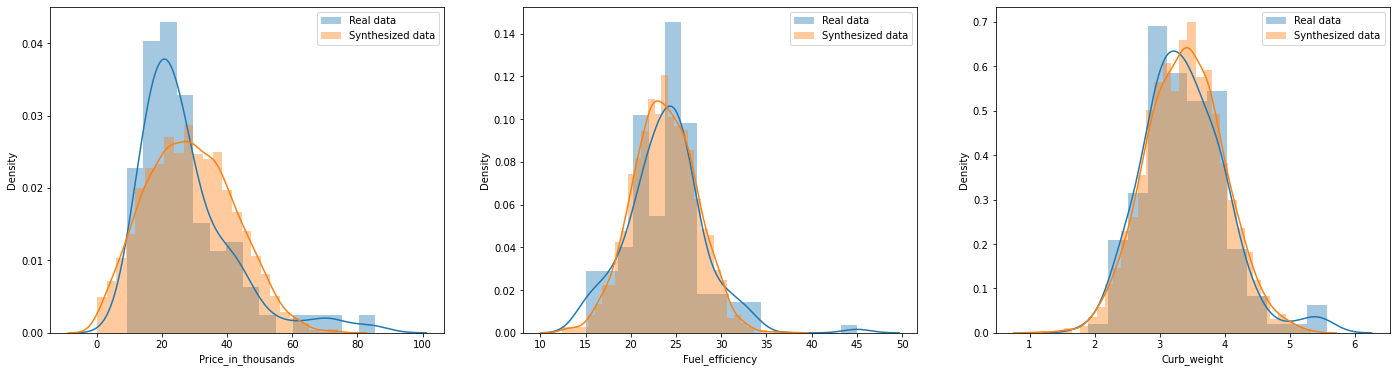

In [40]:
mannual_bn = mannual_est(['Price_in_thousands','Fuel_efficiency','Curb_weight'], bn)

**Structure leraning, using methods**

In [57]:
def method_est(features, method, score):

  bn = structure_learning(discrete_data[chosen_features], method, nodes_type)

  draw_BN(bn, nodes_type, method)

  data['Tax_type'] = data['Tax_type'].astype(float)
  params = parameter_learning(data[chosen_features], nodes_type, bn, 'simple')

  save_structure(bn, 'car_sales_structure')
  skel = read_structure('car_sales_structure')
  save_params(params, 'car_sales_param')
  params = read_params('car_sales_param')
  car_sales_bn = HyBayesianNetwork(skel, params)

  synth_data = generate_synthetics(car_sales_bn, nodes_sign, 'simple', 2000)

  plt.figure(figsize=(24,6))
  counter = 1
  
  for feature in features:

    plt.subplot(1,3,counter)
    sns.distplot(data[feature], label='Real data')
    sns.distplot(synth_data[feature], label='Synthesized data')
    plt.legend()

    counter += 1

  return car_sales_bn

Hill Climb method

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot

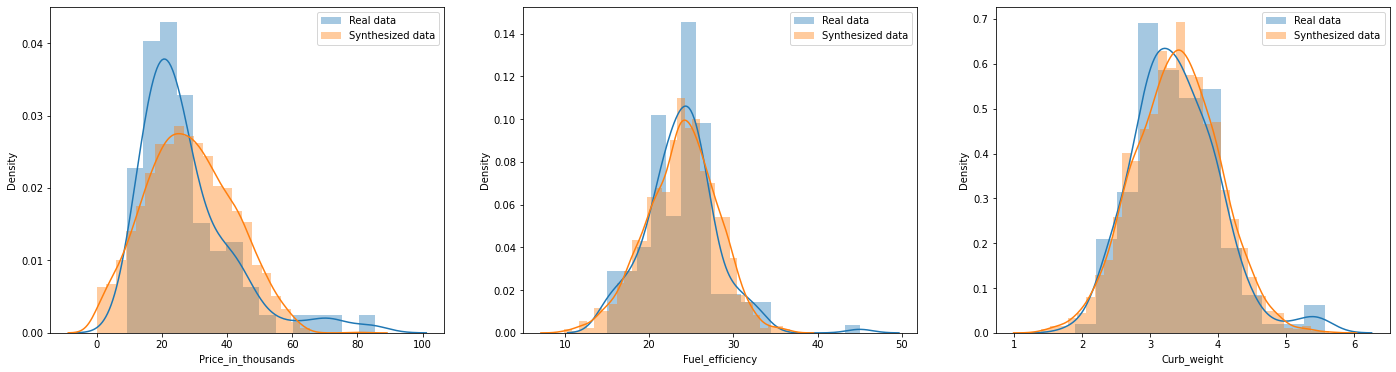

In [42]:
hc_bn = method_est(['Price_in_thousands', 'Fuel_efficiency', 'Curb_weight'], 'HC', 'LL')

EVO method

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


Best metric is 10.7783
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 10.7783
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.2 min
Best metric is 10.7783
Generation num: 2
max_depth: 6, no improvements: 2
spent time: 0.2 min
Best metric is 10.7783
Generation num: 3
max_depth: 6, no improvements: 3
spent time: 0.3 min
Best metric is 10.7783
Generation num: 4
max_depth: 6, no improvements: 4
spent time: 0.4 min
Best metric is 10.7783
Generation num: 5
max_depth: 6, no improvements: 5
spent time: 0.4 min
Best metric is 10.7783
Generation num: 6
max_depth: 6, no improvements: 6
spent time: 0.6 min
Best metric is 10.7783
Generation num: 7
max_depth: 6, no improvements: 7
spent time: 0.6 min
Best metric is 10.764600000000002
Generation num: 8
max_depth: 6, no improvements: 0
spent time: 0.7 min
Best metric is 10.7646
Generation num: 9
max_depth: 6, no improvements: 1
spent time: 0.7 min
Best metric is 10.7604
Generation num: 10
max_dep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot

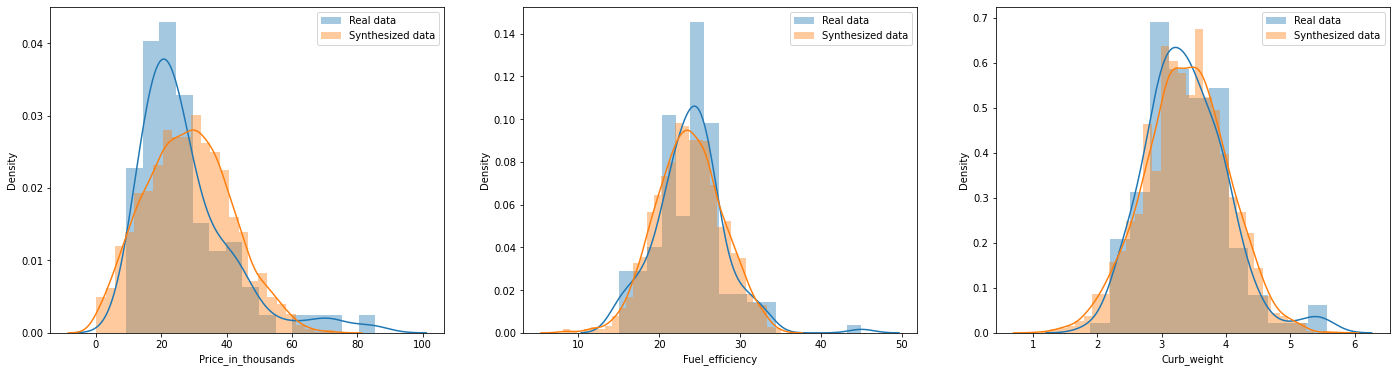

In [43]:
evo_bn = method_est(['Price_in_thousands', 'Fuel_efficiency', 'Curb_weight'], 'evo', 'LL')

**Accuracy**

In [44]:
train = data.sample(frac=0.8)
train = train.reset_index(drop=True)
common = data.merge(train, indicator=True, how='outer')
test = common[(common['_merge']=='left_only')]
test = test.reset_index(drop=True)

In [45]:
coded_data_train, coder_train = code_categories(train, 'label', ['Manufacturer', 'Country'])
discrete_data_train, coder_train = discretization(coded_data_train, 'equal_frequency', ['Price_in_thousands','Fuel_efficiency','Power_perf_factor','Wheelbase','Engine_size','Horsepower','Fuel_capacity','Length','Curb_weight'])
discrete_data_train['Tax_type'] = train['Tax_type'].astype(int)

coded_data_test, coder_test = code_categories(test, 'label', ['Manufacturer', 'Country'])
discrete_data_test, coder_test = discretization(coded_data_test, 'equal_frequency', ['Price_in_thousands','Fuel_efficiency','Power_perf_factor','Wheelbase','Engine_size','Horsepower','Fuel_capacity','Length','Curb_weight'])
discrete_data_test['Tax_type'] = test['Tax_type'].astype(int)

In [54]:
def train_mannual():

  data_for_mannual = train[chosen_features]

  params = parameter_learning(data_for_mannual, nodes_type, bn, 'simple')

  save_structure(bn, 'car_sales_structure')
  skel = read_structure('car_sales_structure')
  save_params(params, 'car_sales_param')
  params = read_params('car_sales_param')
  car_sales_bn = HyBayesianNetwork(skel, params)

  return car_sales_bn

In [49]:
def train_method(method, score):

  n_t = None

  if method == 'evo':

    n_t = nodes_type.copy()
    n_t['Tax_type'] = 'disc'

  bn = structure_learning(discrete_data_train[chosen_features], method, nodes_type)

  params = parameter_learning(train[chosen_features], nodes_type, bn, 'simple')

  save_structure(bn, 'car_sales_structure')
  skel = read_structure('car_sales_structure')
  save_params(params, 'car_sales_param')
  params = read_params('car_sales_param')
  car_sales_bn = HyBayesianNetwork(skel, params)

  return car_sales_bn

Mannual structure

In [55]:
calculate_acc(train_mannual(), test[chosen_features], ['Price_in_thousands','Fuel_efficiency','Curb_weight'], 'simple')[0:2]

({},
 {'Curb_weight': 0.28, 'Fuel_efficiency': 1.819, 'Price_in_thousands': 4.995})

In [ ]:
data[chosen_features]

Hill Climb method

In [50]:
calculate_acc(train_method('HC', 'LL'), test[chosen_features], ['Price_in_thousands','Fuel_efficiency','Curb_weight'], 'simple')[0:2]

({},
 {'Curb_weight': 0.539,
  'Fuel_efficiency': 4.448,
  'Price_in_thousands': 11.869})

EVO method

In [52]:
calculate_acc(train_method('evo', 'LL'), test[chosen_features], ['Price_in_thousands','Fuel_efficiency','Curb_weight'], 'simple')[0:2]

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


Best metric is 12.087499999999999
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 12.087499999999999
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.1 min
Best metric is 12.087499999999999
Generation num: 2
max_depth: 6, no improvements: 2
spent time: 0.1 min
Best metric is 12.087499999999999
Generation num: 3
max_depth: 6, no improvements: 3
spent time: 0.2 min
Best metric is 12.087499999999999
Generation num: 4
max_depth: 6, no improvements: 4
spent time: 0.2 min
Best metric is 10.9774
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 10.9731
Generation num: 6
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 10.9137
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 10.797
Generation num: 8
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 10.7449
Generation num: 9
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best m

({},
 {'Curb_weight': 0.392,
  'Fuel_efficiency': 2.978,
  'Price_in_thousands': 12.112})